In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader


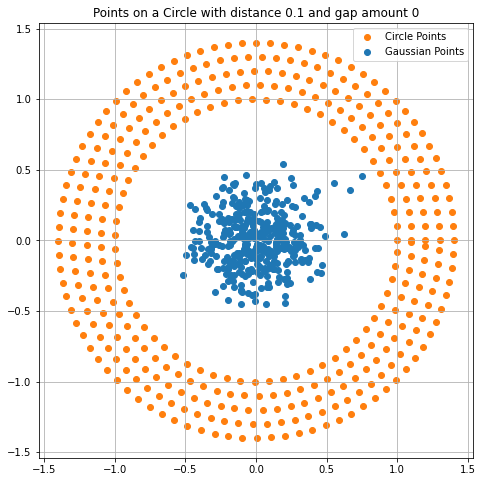

In [27]:
def generate_circle_points(radius, eps, gap_amount, dtype=torch.float32, label_type=torch.int64):
    """
    Generates points on a circle of given radius with a minimum distance between points.

    Args:
        radius (float): Radius of the circle.
        eps (float): Minimum Euclidean distance between points.
        dtype (torch.dtype): Data type for the points.
        label_type (torch.dtype): Data type for the labels.

    Returns:
        tuple: (points, labels) where points are of type dtype and labels are of type label_type.
    """
    points = []
    angle_step = 2 * np.arcsin(eps / (2 * radius))  # Approximation for minimum angle

    angle = 0.0
    while angle < 2 * np.pi - gap_amount*angle_step:
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        points.append((x, y))
        angle += angle_step

    points = torch.tensor(points, dtype=dtype)
    labels = torch.ones(points.size(0), dtype=label_type)  # Assign label 1 to all points

    return points, labels

def generate_gaussian_points(count, mean, std_dev, dtype=torch.float32, label_type=torch.int64):
    """
    Generates Gaussian-distributed points around a given mean with standard deviation.

    Args:
        count (int): Number of points to generate.
        mean (float): Mean value for Gaussian distribution.
        std_dev (float): Standard deviation for Gaussian distribution.
        dtype (torch.dtype): Data type for the points.
        label_type (torch.dtype): Data type for the labels.

    Returns:
        tuple: (points, labels) where points are of type dtype and labels are of type label_type.
    """
    points = torch.normal(mean=mean, std=std_dev, size=(count, 2), dtype=dtype)
    labels = torch.zeros(count, dtype=label_type)  # Assign label 0 to all points

    return points, labels

# Parameters for the circle
radii = [1.,1.1,1.2,1.3,1.4]
epsilon = 0.1
gap_amount = 0

# Generate the dataset for the circle
circle_points_all = torch.zeros(0, dtype=torch.float32)
circle_labels_all = torch.ones(0, dtype=torch.int64)  # Assign label 1 to all points

for radius in radii:
    circle_points, circle_labels = generate_circle_points(radius, epsilon, gap_amount = gap_amount)
    circle_points_all = torch.cat((circle_points_all, circle_points), dim=0)
    circle_labels_all = torch.cat((circle_labels_all, circle_labels), dim=0)        
    

# Generate Gaussian-distributed points
num_gaussian_points = circle_points_all.size(0)
mean = 0.0
std_dev = 0.2
gaussian_points, gaussian_labels = generate_gaussian_points(num_gaussian_points, mean, std_dev)

# Combine datasets
all_points = torch.cat((circle_points_all, gaussian_points), dim=0)
all_labels = torch.cat((circle_labels_all, gaussian_labels), dim=0)



# Plot the points
plt.figure(figsize=(8, 8))
plt.scatter(circle_points_all[:, 0].numpy(), circle_points_all[:, 1].numpy(), color='C1', label='Circle Points')
plt.scatter(gaussian_points[:, 0].numpy(), gaussian_points[:, 1].numpy(), color='C0', label='Gaussian Points')
plt.title(f'Points on a Circle with distance {epsilon} and gap amount {gap_amount}')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
batch_size = 10
plotlim = [-2,2]

# Create a DataLoader
dataset = TensorDataset(all_points, all_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for data in dataloader:
    print(data)
    break

[tensor([[-0.3943,  0.1592],
        [-0.0813,  0.1104],
        [ 0.7517,  0.8031],
        [ 1.1994, -0.0376],
        [ 0.0377,  0.0566],
        [ 0.8154, -0.7383],
        [-0.0690,  0.4643],
        [-0.0598, -0.3734],
        [ 1.1627,  0.2970],
        [ 0.1762,  0.2023]]), tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 0])]


In [29]:

# Define a feed-forward network with 5 layers, each of constant width 2.
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        # Create a list of 5 linear layers (2x2 each)
        self.layers = nn.ModuleList([nn.Linear(2,3), nn.Linear(3,3),nn.Linear(3,2)])
    
    def forward(self, x):
        # Apply ReLU activation for the first n-1 layers; final layer outputs logits.
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        return x


# Training loop using a DataLoader.
def train_model(model, dataloader, epochs=100, lr=0.01):
    criterion = nn.CrossEntropyLoss()  # Suitable for binary classification (2 classes).
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Helper function to compute the matrix rank with a fallback for older PyTorch versions.
def compute_matrix_rank(matrix):
    try:
        # If available (PyTorch 1.9+), use torch.linalg.matrix_rank
        rank = torch.linalg.matrix_rank(matrix)
    except AttributeError:
        # Fallback for older PyTorch versions: compute SVD and count nonzero singular values.
        U, S, V = torch.svd(matrix)
        tol = S.max() * max(matrix.size()) * torch.finfo(S.dtype).eps
        rank = (S > tol).sum()
    return rank.item()

# Print the rank of each weight matrix in the model.
def print_weight_ranks(model):
    print("\nWeight Matrix Ranks:")
    for idx, layer in enumerate(model.layers):
        weight = layer.weight.data
        rank = compute_matrix_rank(weight)
        print(f"Layer {idx+1} weight matrix rank: {rank}")

# Main execution: training the network and printing weight ranks.
if __name__ == "__main__":
    # Set a seed for reproducibility.
    torch.manual_seed(42)
    
    model = FeedForwardNN()
    train_model(model, dataloader, epochs=200, lr=0.01)
    print_weight_ranks(model)


Epoch 20/200, Loss: 0.0074
Epoch 40/200, Loss: 0.0021
Epoch 60/200, Loss: 0.0019
Epoch 80/200, Loss: 0.0009
Epoch 100/200, Loss: 0.0002
Epoch 120/200, Loss: 0.0001
Epoch 140/200, Loss: 0.0001
Epoch 160/200, Loss: 0.0002
Epoch 180/200, Loss: 0.0001
Epoch 200/200, Loss: 0.0001

Weight Matrix Ranks:
Layer 1 weight matrix rank: 2
Layer 2 weight matrix rank: 3
Layer 3 weight matrix rank: 2


In [30]:
model(torch.tensor([1.,1.]))

class TwoOutputWrapper(nn.Module):
    def __init__(self, model):
        super(TwoOutputWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Get the primary output from the original model.
        primary_output = self.model(x)
        # Create a dummy second output: zeros with the same shape as the primary output.
        dummy_output = torch.zeros_like(primary_output)
        return primary_output, dummy_output

# Assume that 'model' is your trained FeedForwardNN instance.
# For example, if you trained your model as follows:
# model = FeedForwardNN()
# ... (training code) ...
#
# You now wrap the model:
wrapped_model = TwoOutputWrapper(model)

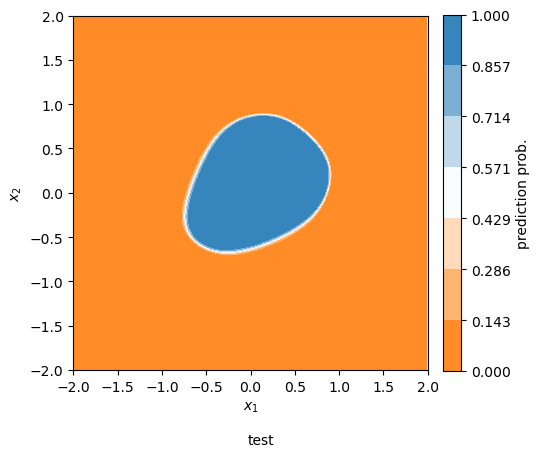

In [31]:
from plots.plots import classification_levelsets

wrapped_model = TwoOutputWrapper(model)

# footnote = f'{num_params = }, {time_steps = }, {gap_amount = }, standard training'
footnote = 'test'
fig_name = 'feedforward'
_, ax = classification_levelsets(wrapped_model, plotlim = plotlim,
                         footnote=footnote)



plt.savefig(fig_name + '.png', bbox_inches='tight',
            dpi=300, format='png', facecolor='white')


plt.show()

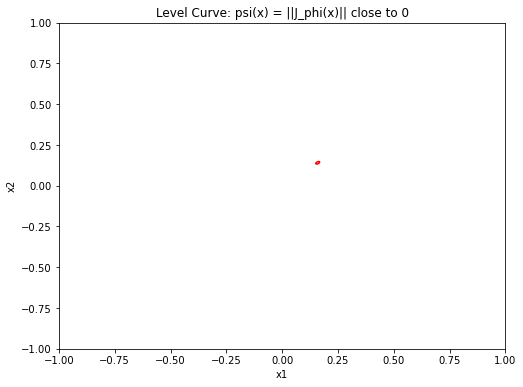

In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to compute psi(x) = ||J_phi(x)||_F
def psi_manual(x, model):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^2.
    
    Returns:
      The Frobenius norm of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    y = model(x)  # y should be of shape (2,)
    
    # Compute the Jacobian manually: for each output dimension, compute grad(y_i) wrt x.
    jacobian_rows = []
    for i in range(y.shape[0]):
        # Compute gradient of y[i] with respect to x.
        grad_i, = torch.autograd.grad(y[i], x, retain_graph=True, create_graph=True)
        jacobian_rows.append(grad_i)
    # Stack to form a 2x2 Jacobian.
    jacobian = torch.stack(jacobian_rows)
    # Compute and return the Frobenius norm.
    return jacobian.norm().item()

# Define a grid over the input space.
grid_size = 1000  # Adjust as needed.
x_range = np.linspace(-1, 1, grid_size)
y_range = np.linspace(-1, 1, grid_size)
psi_values = np.zeros((grid_size, grid_size))

# Put the model in evaluation mode.
model.eval()

# Evaluate psi(x) over the grid.
for i, xv in enumerate(x_range):
    for j, yv in enumerate(y_range):
        # Create a 2D point as a torch tensor.
        x_point = torch.tensor([xv, yv], dtype=torch.float32)
        psi_values[j, i] = psi_manual(x_point, model)

# Plot the contour corresponding to psi ~ 0.
plt.figure(figsize=(8, 6))
# Here we plot the contour at a small level, e.g., 0.01.
CS = plt.contour(x_range, y_range, psi_values, levels=[0.1], colors='red')
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Level Curve: psi(x) = ||J_phi(x)|| close to 0')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()
